In [1]:
import numpy as np
import pandas as pd
import datetime as dt

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge, ElasticNetCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [2]:
data = pd.read_csv('BTCUSDT_Binance_futures_data_day.csv',skiprows=1)

In [3]:
i=1
data['y1'] = data[['close']].shift(i)

In [ ]:
mae
rmse
mape


In [4]:
data['y1'].fillna(method='bfill', inplace=True)

In [5]:
data.date = pd.to_datetime(data.date)

In [6]:
data.set_index('date',inplace= True)

In [7]:
data = data.asfreq('d')

In [8]:
data.drop(columns=['unix','symbol'], inplace=True)

In [9]:
data['mavg10'] = data['close'].rolling(window=10, min_periods=1, center=False).mean()

In [10]:
data['mavg60'] = data['close'].rolling(window=60, min_periods=1, center=False).mean()

In [11]:
MA_50 = data['close'].rolling(window = 50).mean()  
data['MA_50'] = MA_50 
MA_20 = data['close'].rolling(window = 20).mean() 
data['MA_20'] = MA_20 

In [12]:
data['MA_50'].fillna(method='bfill', inplace=True)
data['MA_20'].fillna(method='bfill', inplace=True)

In [13]:
data['hajmbtc']=data['Volume BTC']/data['tradecount']

In [14]:
data['hajmusdt']=data['Volume USDT']/data['tradecount']

In [15]:
data['meanopenclose']=(data['open']+data['close'])/2

In [16]:
data['meanlowhigh']=(data['low']+data['high'])/2

In [17]:
data['diff']=data['y1']-data['close']

In [18]:
data['year_change'] = 100*(data['close'] - data['open']) / data['open']

In [19]:
timesteps=data.drop(['y1'],axis=1)
prices = data["y1"]

In [20]:
split_size = int(0.8 * len(timesteps))
split_size1 = int(0.8 * len(prices))
x_train, y_train = timesteps[:split_size], prices[:split_size1]

x_test, y_test = timesteps[split_size:], prices[split_size1:]

len(x_train), len(x_test), len(y_train), len(y_test)

(883, 221, 883, 221)

In [21]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(x_train, y_train)

print('Random Forest R squared": %.4f' % forest_reg.score(x_test, y_test))

cross_validation = forest_reg.predict(x_test)

confidence = forest_reg.score(x_test, y_test)
print("confidence: ", confidence)

forecast_prediction = forest_reg.predict(x_test)
print(forecast_prediction)

Random Forest R squared": 0.8524
confidence:  0.852395664084158
[44574.0531 44804.1729 44242.5778 43041.9101 42357.1465 42068.7332
 42291.115  43731.1531 44646.1851 43244.7941 39841.6681 40176.2252
 38767.7605 37166.6631 38822.3366 36937.4389 38888.3651 38871.9595
 39049.9995 38439.3331 40456.4703 43410.1252 44687.307  43963.2761
 40085.8203 39983.6801 38810.7879 38304.1272 38620.9693 40402.3803
 40275.5941 39104.6158 39330.4594 37811.0173 39807.9383 38971.4042
 41221.5782 41392.5813 42212.234  42254.6788 41435.9802 41396.2535
 42603.762  42828.4017 43555.297  44606.3391 45079.8406 46425.3989
 46866.0221 47453.6863 46962.1735 45633.7603 46368.6074 45505.1059
 46328.4303 46085.3236 45578.3012 44072.1069 43192.1031 42152.6006
 42631.0046 42119.4169 40102.6168 40234.1158 41215.6778 40938.4487
 40469.8888 40369.7786 39578.3953 41473.1378 42080.5667 41771.6298
 41261.0807 39246.7821 39794.8418 40149.9417 40706.9809 38069.354
 40144.9193 39468.3565 38858.6801 37856.5655 38579.5176 38226.906


In [22]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
ss = StandardScaler()

# This will scale the features using the z-score
zscore = ss.fit_transform(timesteps)

#recreate the df
features_ss = pd.DataFrame(zscore, index = timesteps.index, columns = timesteps.columns)
features_ss = features_ss.reset_index(drop=True)
print(features_ss.head())

       open      high       low     close  Volume BTC  Volume USDT  \
0 -0.989279 -0.982281 -0.972307 -0.968461   -1.499579    -1.187726   
1 -0.971646 -0.978877 -0.967857 -0.973176   -1.447839    -1.173653   
2 -0.972182 -0.983887 -0.975714 -0.984596   -1.473229    -1.180637   
3 -0.984029 -0.988751 -0.978972 -0.981391   -1.465161    -1.178641   
4 -0.980198 -0.980252 -0.969880 -0.967152   -1.444374    -1.172829   

   tradecount    mavg10    mavg60     MA_50     MA_20   hajmbtc  hajmusdt  \
0   -1.195558 -0.968429 -0.966789 -1.049473 -0.999818  3.646762  4.518385   
1   -1.192038 -0.970792 -0.969185 -1.049473 -0.999818  6.610675  9.369708   
2   -1.192602 -0.975396 -0.973853 -1.049473 -0.999818  4.097208  5.146244   
3   -1.190864 -0.976895 -0.975372 -1.049473 -0.999818  3.429603  3.929159   
4   -1.187948 -0.974939 -0.973389 -1.049473 -0.999818  3.363169  3.930798   

   meanopenclose  meanlowhigh      diff  year_change  
0      -0.979485    -0.978050 -0.073639     0.964409  
1     

In [23]:
# minmax
mm = MinMaxScaler()
minmax = mm.fit_transform(timesteps)

#create a df again
features_mm = pd.DataFrame(minmax, index=timesteps.index, columns=timesteps.columns)
features_mm = features_mm.reset_index(drop=True)
print(features_mm.head())

       open      high       low     close  Volume BTC  Volume USDT  \
0  0.083344  0.079129  0.101761  0.089541    0.000000     0.000000   
1  0.088382  0.080114  0.102993  0.088195    0.007242     0.002274   
2  0.088229  0.078664  0.100818  0.084933    0.003688     0.001145   
3  0.084844  0.077256  0.099915  0.085848    0.004818     0.001468   
4  0.085939  0.079716  0.102433  0.089915    0.007727     0.002407   

   tradecount    mavg10    mavg60     MA_50     MA_20   hajmbtc  hajmusdt  \
0    0.000000  0.082428  0.064147  0.040538  0.067796  0.607459  0.575256   
1    0.000511  0.081713  0.063346  0.040538  0.067796  1.000000  1.000000   
2    0.000430  0.080320  0.061787  0.040538  0.067796  0.667116  0.630226   
3    0.000682  0.079867  0.061279  0.040538  0.067796  0.578699  0.523668   
4    0.001106  0.080458  0.061941  0.040538  0.067796  0.569900  0.523811   

   meanopenclose  meanlowhigh      diff  year_change  
0       0.080936     0.086295  0.477690     0.737155  
1     

In [24]:
features_group = {'standard_scaler': features_ss, 'min_max_scaler': features_mm, 'no_scaling': timesteps}

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
results_df = pd.DataFrame()

In [26]:
for key, curr_features in features_group.items():
   
    model = LinearRegression()
    model.fit(x_train, y_train)

    # get the predictions for the test dataset
    predictions = model.predict(x_test)

    # R-squared training
    r2_train = model.score(x_train, y_train)

    # R-squared testing
    r2_test = model.score(x_test, y_test)

    #Compare predictions with Y_test
    mse = mean_squared_error(y_test, predictions)

    #Root Mean Squared Error
    rmse=mse**0.5
                    
    results_df = results_df.append({'Model': 'Linear Regression', 'Scaling': key,
                    'RMSE': rmse, 'R2_Test': r2_test, 'R2_Train': r2_train}, ignore_index=True)
    
results_df 

,Model,Scaling,RMSE,R2_Test,R2_Train
0,Linear Regression,standard_scaler,8.582869e-11,1.0,1.0
1,Linear Regression,min_max_scaler,8.582869e-11,1.0,1.0
2,Linear Regression,no_scaling,8.582869e-11,1.0,1.0


In [27]:
feat = list(x_train.columns)
coef=model.coef_.transpose()
coef_table = np.stack((feat,coef)).T
df_coef = pd.DataFrame(coef_table, columns=['Feature','Coefficients'])
df_coef

,Feature,Coefficients
0,open,-0.1666666666666632
1,high,5.967510773696635e-12
2,low,5.9591144037359376e-12
3,close,0.8333333333333355
4,Volume BTC,-5.81365685561357e-16
5,Volume USDT,2.219663267024197e-20
6,tradecount,-1.3926778918505126e-17
7,mavg10,-1.2945787676739948e-15
8,mavg60,-2.6000683630166845e-16
9,MA_50,-6.352379847242218e-16


In [28]:
from sklearn.linear_model import Ridge, Lasso 
from sklearn.model_selection import GridSearchCV

In [29]:
for key, curr_features in features_group.items():
   
    grid_parameters = {'alpha': np.linspace(10,0,100)}

    grid = GridSearchCV(Lasso(), grid_parameters, cv=5, scoring='neg_mean_squared_error')
    grid.fit(x_train, y_train)
    best_lasso_alpha=grid.best_estimator_.alpha
    
    lasso = Lasso(alpha=best_lasso_alpha)
    
    #fit model
    lasso.fit(x_train, y_train)
    
    lasso_pred = lasso.predict(x_test)
    
    # R-squared training
    r2_train = lasso.score(x_train, y_train)

    # R-squared testing
    r2_test = lasso.score(x_test, y_test)

    mse = np.mean((lasso_pred - y_test)**2) 
    rmse = mse**0.5

    results_df = results_df.append({'Model': 'Lasso Regression', 'Scaling': key,
                'RMSE': rmse, 'R2_Test': r2_test, 'R2_Train': r2_train, 'Params': 'Alpha = ' + str(best_lasso_alpha)}, ignore_index=True)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65020328.77279212, tolerance: 25805896.4654032
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62258304.28957911, tolerance: 26118121.7764143
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76825425.7467177, tolerance: 30279890.632110287
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning:

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76779651.57723261, tolerance: 30279890.632110287
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53201957.79754526, tolerance: 23995897.85987879
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51837923.515792824, tolerance: 20458464.016090497
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWar

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62078385.07623587, tolerance: 26118121.7764143
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76720727.32816002, tolerance: 30279890.632110287
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53154271.17528618, tolerance: 23995897.85987879
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarnin

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61976971.13348153, tolerance: 26118121.7764143
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76661722.36545792, tolerance: 30279890.632110287
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53106507.373304546, tolerance: 23995897.85987879
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarni

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53063987.17289556, tolerance: 23995897.85987879
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51707912.692285694, tolerance: 20458464.016090497
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64798581.01556925, tolerance: 25805896.4654032
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarni

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76556632.40221083, tolerance: 30279890.632110287
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53021407.42633155, tolerance: 23995897.85987879
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51667796.26032862, tolerance: 20458464.016090497
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarn

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76503999.99439724, tolerance: 30279890.632110287
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52978772.67984243, tolerance: 23995897.85987879
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51627644.80054442, tolerance: 20458464.016090497
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarn

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76451325.04187287, tolerance: 30279890.632110287
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52936086.81665447, tolerance: 23995897.85987879
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51587492.10427581, tolerance: 20458464.016090497
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarn

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61513001.38707096, tolerance: 26118121.7764143
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76392169.403511, tolerance: 30279890.632110287
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52888046.66279138, tolerance: 23995897.85987879
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning:

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52840052.76738654, tolerance: 23995897.85987879
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51498029.83261451, tolerance: 20458464.016090497
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64522796.370170705, tolerance: 25805896.4654032
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarni

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64630901.721427746, tolerance: 25805896.4654032
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61840858.04045261, tolerance: 26118121.7764143
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76284281.85616824, tolerance: 30279890.632110287
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarnin

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65045620.22258034, tolerance: 25805896.4654032
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61981760.53091511, tolerance: 26118121.7764143
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76264506.65423533, tolerance: 30279890.632110287
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52006648.52042572, tolerance: 20458464.016090497
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 83471666.58349057, tolerance: 33405841.89756827
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 83471666.58349057, tolerance: 33405841.89756827
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarni

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51837923.515792824, tolerance: 20458464.016090497
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64968272.289611466, tolerance: 25805896.4654032
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62168404.78107989, tolerance: 26118121.7764143
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarni

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64922663.49756898, tolerance: 25805896.4654032
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62089644.010016285, tolerance: 26118121.7764143
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76727278.45280373, tolerance: 30279890.632110287
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarnin

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62010792.48880792, tolerance: 26118121.7764143
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76681399.65453945, tolerance: 30279890.632110287
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53122437.30138233, tolerance: 23995897.85987879
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarnin

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76622340.88275073, tolerance: 30279890.632110287
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53074622.795392975, tolerance: 23995897.85987879
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51717935.063639924, tolerance: 20458464.016090497
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51677830.48901668, tolerance: 20458464.016090497
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64759312.16051796, tolerance: 25805896.4654032
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61807606.156333156, tolerance: 26118121.7764143
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarnin

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52984105.069423415, tolerance: 23995897.85987879
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51632665.414433375, tolerance: 20458464.016090497
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64700330.2707785, tolerance: 25805896.4654032
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarni

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51587492.10427581, tolerance: 20458464.016090497
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64641253.77302898, tolerance: 25805896.4654032
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61603794.67490837, tolerance: 26118121.7764143
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61501641.806954436, tolerance: 26118121.7764143
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76385667.44883071, tolerance: 30279890.632110287
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52882710.736658916, tolerance: 23995897.85987879
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarn

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61422065.21204969, tolerance: 26118121.7764143
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76341770.62920627, tolerance: 30279890.632110287
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52845382.19348561, tolerance: 23995897.85987879
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarnin

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61806302.09693228, tolerance: 26118121.7764143
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76289741.09804486, tolerance: 30279890.632110287
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52797445.05667359, tolerance: 23995897.85987879
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarnin

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61977043.408042, tolerance: 26118121.7764143
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76248133.39901873, tolerance: 30279890.632110287
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52761814.531028055, tolerance: 23995897.85987879
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52962716.89982602, tolerance: 23995897.85987879
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51978215.11494188, tolerance: 20458464.016090497
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64987801.952397466, tolerance: 25805896.4654032
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62202131.46631299, tolerance: 26118121.7764143
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76792734.89369285, tolerance: 30279890.632110287
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarnin

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76746925.84794842, tolerance: 30279890.632110287
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53175474.5963597, tolerance: 23995897.85987879
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51812970.1385098, tolerance: 20458464.016090497
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarnin

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62033330.776947975, tolerance: 26118121.7764143
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76694512.86493932, tolerance: 30279890.632110287
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53133052.42499951, tolerance: 23995897.85987879
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarni

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64837809.16157362, tolerance: 25805896.4654032
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61943133.070413955, tolerance: 26118121.7764143
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76642036.10819525, tolerance: 30279890.632110287
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarnin

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76596066.63165504, tolerance: 30279890.632110287
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53053347.53828338, tolerance: 23995897.85987879
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51697887.191058956, tolerance: 20458464.016090497
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWar

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76543479.81251371, tolerance: 30279890.632110287
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53010755.108002916, tolerance: 23995897.85987879
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51657761.749701865, tolerance: 20458464.016090497
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52968105.21803238, tolerance: 23995897.85987879
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51617604.71884983, tolerance: 20458464.016090497
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64680648.28177879, tolerance: 25805896.4654032
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarnin

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64628112.11683967, tolerance: 25805896.4654032
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61581108.98336186, tolerance: 26118121.7764143
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76431570.73044515, tolerance: 30279890.632110287
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76372820.99281731, tolerance: 30279890.632110287
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52872041.14168163, tolerance: 23995897.85987879
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51527556.06169222, tolerance: 20458464.016090497
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarn

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64503006.46451218, tolerance: 25805896.4654032
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61630789.42910741, tolerance: 26118121.7764143
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76312239.76024511, tolerance: 30279890.632110287
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52770836.403724, tolerance: 23995897.85987879
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51539138.184427656, tolerance: 20458464.016090497
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64907128.27236267, tolerance: 25805896.4654032
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76647179.16461504, tolerance: 30279890.632110287
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52962716.89982602, tolerance: 23995897.85987879
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51978215.11494188, tolerance: 20458464.016090497
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: UserWarning: With al

In [30]:
results_df

,Model,Scaling,RMSE,R2_Test,R2_Train,Params
0,Linear Regression,standard_scaler,8.582869e-11,1.000000,1.000000,NaN
1,Linear Regression,min_max_scaler,8.582869e-11,1.000000,1.000000,NaN
2,Linear Regression,no_scaling,8.582869e-11,1.000000,1.000000,NaN
3,Lasso Regression,standard_scaler,3.305485e+02,0.998724,0.999507,Alpha = 10.0
4,Lasso Regression,min_max_scaler,3.305485e+02,0.998724,0.999507,Alpha = 10.0
5,Lasso Regression,no_scaling,3.305485e+02,0.998724,0.999507,Alpha = 10.0


Best degree: {'poly__degree': 1}


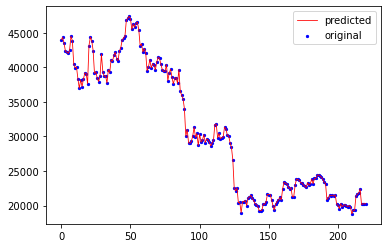

Best degree: {'poly__degree': 1}


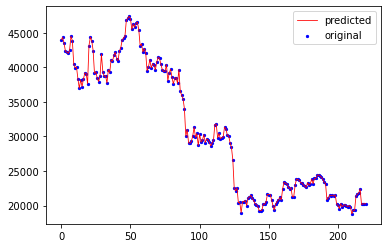

Best degree: {'poly__degree': 1}


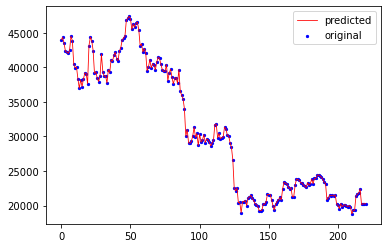

In [31]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
for key, curr_features in features_group.items():
    
    rmse_list=[]
    r2_list =[]
    linear_model = LinearRegression()

    #poly degrees to search
    param_grid = {'poly__degree': np.arange(1,6,1)}

    steps = []
    # create and fit a ridge regression model, testing each alpha
    steps=[('poly', PolynomialFeatures()), ('linear', linear_model)]
    pipeline = Pipeline(steps)

    cv = GridSearchCV(pipeline, param_grid, cv=5, 
                      scoring='neg_mean_squared_error',
                      return_train_score=True)
    #feature_transform=cv.fit_transform(features_p1)
    cv.fit(x_train, y_train)
    best_poly_deg = cv.best_params_['poly__degree']
    print("Best degree:", cv.best_params_)   

    #define poly object with degree
    pre_poly = PolynomialFeatures(degree=best_poly_deg)
    #transform X to use in poly
    X_train_poly = pre_poly.fit_transform(x_train)
    X_test_poly = pre_poly.transform(x_test)
    #create regression object
    pol_reg = LinearRegression()
    #fit model
    pol_reg.fit(X_train_poly, y_train)

    #store predicted price 
    y_predict = pol_reg.predict(X_test_poly)

    #find r-squared
    r2_train = pol_reg.score(X_train_poly, y_train)
    r2_test=pol_reg.score(X_test_poly, y_test)

    #find rmse
    mse = np.mean((y_predict - y_test)**2) 
    rmse=mse**0.5

    # Plot the prediction vs actual values
    x_ax = range(len(y_predict))
    plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
    plt.plot(x_ax, y_predict, lw=0.8, color="red", label="predicted")
    plt.legend()
    plt.show()

    results_df = results_df.append({'Model': 'Polynomial Regression (Linear)', 'Scaling': key, 'Params': 'Degree = ' + str(best_poly_deg),
                'RMSE': rmse, 'R2_Test': r2_test, 'R2_Train': r2_train}, ignore_index=True)

In [32]:
results_df

,Model,Scaling,RMSE,R2_Test,R2_Train,Params
0,Linear Regression,standard_scaler,8.582869e-11,1.000000,1.000000,NaN
1,Linear Regression,min_max_scaler,8.582869e-11,1.000000,1.000000,NaN
2,Linear Regression,no_scaling,8.582869e-11,1.000000,1.000000,NaN
3,Lasso Regression,standard_scaler,3.305485e+02,0.998724,0.999507,Alpha = 10.0
4,Lasso Regression,min_max_scaler,3.305485e+02,0.998724,0.999507,Alpha = 10.0
5,Lasso Regression,no_scaling,3.305485e+02,0.998724,0.999507,Alpha = 10.0
6,Polynomial Regression (Linear),standard_scaler,5.099642e-07,1.000000,1.000000,Degree = 1
7,Polynomial Regression (Linear),min_max_scaler,5.099642e-07,1.000000,1.000000,Degree = 1
8,Polynomial Regression (Linear),no_scaling,5.099642e-07,1.000000,1.000000,Degree = 1


In [33]:
for key, curr_features in features_group.items():
    
    grid_parameters = {'max_depth': np.arange(2,10,1)}

    grid = GridSearchCV(RandomForestRegressor(), grid_parameters, cv=5, scoring='neg_mean_squared_error')
    grid.fit(x_train, y_train)
    best_para=grid.best_estimator_.max_depth
  
    rf_reg = RandomForestRegressor(max_depth=best_para, max_features=None)
    
    #fit model
    rf_reg.fit(x_train, y_train)
    
    rf_pred = rf_reg.predict(x_test)
    
    # R-squared training
    r2_train = rf_reg.score(x_train, y_train)

    # R-squared testing
    r2_test = rf_reg.score(x_test, y_test)

    mse = np.mean((rf_pred - y_test)**2) 
    rmse = mse**0.5

    results_df = results_df.append({'Model': 'RandomForest Regressor', 'Scaling': key,
                'RMSE': rmse, 'R2_Test': r2_test, 'R2_Train': r2_train, 'Params': 'max_depth = ' + str(best_para)}, ignore_index=True)

In [34]:
results_df = results_df.sort_values(by=['RMSE'])
results_df

,Model,Scaling,RMSE,R2_Test,R2_Train,Params
0,Linear Regression,standard_scaler,8.582869e-11,1.000000,1.000000,NaN
1,Linear Regression,min_max_scaler,8.582869e-11,1.000000,1.000000,NaN
2,Linear Regression,no_scaling,8.582869e-11,1.000000,1.000000,NaN
6,Polynomial Regression (Linear),standard_scaler,5.099642e-07,1.000000,1.000000,Degree = 1
7,Polynomial Regression (Linear),min_max_scaler,5.099642e-07,1.000000,1.000000,Degree = 1
8,Polynomial Regression (Linear),no_scaling,5.099642e-07,1.000000,1.000000,Degree = 1
3,Lasso Regression,standard_scaler,3.305485e+02,0.998724,0.999507,Alpha = 10.0
4,Lasso Regression,min_max_scaler,3.305485e+02,0.998724,0.999507,Alpha = 10.0
5,Lasso Regression,no_scaling,3.305485e+02,0.998724,0.999507,Alpha = 10.0
10,RandomForest Regressor,min_max_scaler,3.473065e+03,0.859109,0.999782,max_depth = 9


In [35]:
data_new = [
    # Positive tweets scenario
    [60000000000, 1, 0.9, 0, 0.1, 100, 1, 0, 0,1,0,1,1,1,0,0,0],
    # Neutral tweets scenario    
    [60000000000, 1, 0, 0, 1, 100, 1, 0, 0,1,0,1,1,1,0,0,0],
    # Negative tweets scenario
    [60000000000, 1, 0, 0.9, 0.1, 100, 1, 0, 0,1,0,1,1,1,0,0,0],
    # Large number of tweets
    [60000000000, 1, 0, 0, 1, 500, 1, 0, 0,1,0,1,1,1,0,0,0],
    # Small number of tweets
    [60000000000, 1, 0, 0, 1, 10, 1, 0, 0,1,0,1,1,1,0,0,0]
           ]

In [36]:
df_new = pd.DataFrame(data_new, columns = ['open', 'high', 'low', 'close', 'Volume BTC', 'Volume USDT',
       'tradecount', 'mavg10', 'mavg60', 'MA_50', 'MA_20', 'hajmbtc',
       'hajmusdt', 'meanopenclose', 'meanlowhigh', 'diff', 'year_change'])


In [37]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_group['no_scaling'])
scaled_new = scaler.transform(df_new)

In [38]:
rf_reg = RandomForestRegressor(max_depth=17, max_features=None,
                                                    random_state=42)

#fit model
rf_reg.fit(scaled_features, prices)

predictions = rf_reg.predict(scaled_new)


print(predictions)

[6162.5052 6162.5052 6162.5052 6162.5052 6162.5052]
